In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

100%|██████████| 170M/170M [00:02<00:00, 83.7MB/s] 


In [4]:
from torch.utils.data import DataLoader

In [5]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
class VQ(nn.Module):
    def __init__(self, n_emb, emb_dim, commitment_cost):
        super(VQ2, self).__init__()
        self.emb_dim = emb_dim
        self.n_emb = n_emb
        self.commitment_cost = commitment_cost
        
        # Simple learnable embeddings (no EMA to start)
        self.embedding = nn.Embedding(n_emb, emb_dim)
        self.embedding.weight.data.uniform_(-1/n_emb, 1/n_emb)
        
    def forward(self, z):
        # z: (B, C, H, W)
        z_ = z.permute(0, 2, 3, 1).contiguous()  # (B, H, W, C)
        z_flat = z_.view(-1, self.emb_dim)  # (BHW, C)
        
        # Calculate distances
        d = torch.sum(z_flat ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight ** 2, dim=1) - \
            2 * torch.matmul(z_flat, self.embedding.weight.t())
        
        # Get nearest embedding
        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z_.shape)
        
        # Compute losses
        e_latent_loss = F.mse_loss(z_q.detach(), z_)
        q_latent_loss = F.mse_loss(z_q, z_.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        # Straight-through estimator
        z_q = z_ + (z_q - z_).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        
        return z_q, loss


In [7]:
class VQ_EMA(nn.Module):
    def __init__(self, n_emb, emb_dim, commitment_cost=0.25, decay=0.99, epsilon=1e-5):
        super(VQ_EMA, self).__init__()
        self.emb_dim = emb_dim
        self.n_emb = n_emb
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        # Initialize embeddings properly (centered around 0, small values)
        embed = torch.randn(n_emb, emb_dim)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(n_emb))
        self.register_buffer('embed_avg', embed.clone())
        
    def forward(self, z):
        # z: (B, C, H, W)
        B, C, H, W = z.shape
        
        z_flat = z.permute(0, 2, 3, 1).contiguous().view(-1, self.emb_dim)
        
        # Calculate distances (standard L2 distance, no normalization tricks)
        distances = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True) 
            + torch.sum(self.embed ** 2, dim=1)
            - 2 * torch.matmul(z_flat, self.embed.t())
        )
        
        # Get nearest embedding indices
        encoding_indices = torch.argmin(distances, dim=1)
        
        # Quantize
        z_q = F.embedding(encoding_indices, self.embed).view(B, H, W, C)

        encodings = F.one_hot(encoding_indices, self.n_emb).float()
        avg_probs = encodings.mean(0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # EMA update 
        if self.training:
            with torch.no_grad():
                encodings = F.one_hot(encoding_indices, self.n_emb).float()
                
                # Update cluster sizes: how many vectors were assigned to each embedding
                self.cluster_size.mul_(self.decay).add_(
                    encodings.sum(0), alpha=1 - self.decay
                )
                
                embed_sum = torch.matmul(encodings.t(), z_flat)
                self.embed_avg.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
                
                # Normalize embeddings by cluster size with Laplace smoothing
                n = self.cluster_size.sum()
                cluster_size = (
                    (self.cluster_size + self.epsilon) 
                    / (n + self.n_emb * self.epsilon) 
                    * n
                )
                
                # Update embeddings: embed = embed_avg / cluster_size
                embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
                self.embed.copy_(embed_normalized)

                
        # Compute loss (only commitment loss, no codebook loss since EMA handles it)
        e_latent_loss = F.mse_loss(z_q.detach(), z.permute(0, 2, 3, 1))
        loss = self.commitment_cost * e_latent_loss
        
        # Straight-through estimator
        z_q = z.permute(0, 2, 3, 1) + (z_q - z.permute(0, 2, 3, 1)).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        
        return z_q, loss, perplexity
   
    def encode(self, z):
        B,C,H,W = z.shape
        z_flat = z.permute(0,2,3,1).contiguous().view(-1, self.emb_dim)
        distances = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True) 
            + torch.sum(self.embed ** 2, dim=1)
            - 2 * torch.matmul(z_flat, self.embed.t())
        )
        encoding_indices = torch.argmin(distances, dim=1)
        return encoding_indices.view(B, H, W)

    def decode_indices(self, indices):
        """Convert indices back to z_q"""
        B, H, W = indices.shape
        z_q = F.embedding(indices.view(-1), self.embed).view(B, H, W, -1)
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return z_q

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, in_channels=3):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4,2,1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, latent_dim,kernel_size=1),
        )
    def forward(self, x):
        out = self.encoder(x)
        return out

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, z_q):
        out = self.decoder(z_q)
        return out

In [10]:
def loss(x_hat, x, comit_loss):
    recon_loss = F.mse_loss(x_hat, x)
    total_loss = recon_loss + comit_loss
    return recon_loss, total_loss

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
encoder = Encoder(latent_dim=64).to(device)
decoder = Decoder(latent_dim=64).to(device)
vq = VQ_EMA(n_emb=512, emb_dim=64, commitment_cost=0.1).to(device)

In [ ]:
import torch.optim as optim
from itertools import chain

In [ ]:
optimizer = optim.Adam(
    chain(vq.parameters(), encoder.parameters(), decoder.parameters()),
    lr=1e-4
)

In [ ]:
import wandb
wandb.login(key='8272ab2d9735b11ac6be1cb7e14dda7118145953')

In [ ]:
wandb.init(
    project="vqvae-final",   # name of your project
    name="run-2",               # optional: specific run name
    config={
        "epochs": 100,
        "batch_size": train_dataloader.batch_size,
        "lr": optimizer.param_groups[0]['lr']
    }
)

In [ ]:
from tqdm import tqdm

In [ ]:
accumulation_step=4

In [ ]:
from torch.cuda.amp import autocast, GradScaler

In [ ]:
scaler = GradScaler()

In [ ]:
import gc

In [ ]:
for epoch in range(100):
    running_total_loss = 0.0
    running_recon_loss = 0.0
    running_perplexity = 0.0
    vq.train()
    encoder.train()
    decoder.train()

    for batch_idx, (images, _) in enumerate(tqdm(train_dataloader, desc=f"{epoch+1}")):
        x = images.to(device, non_blocking=True)

        with autocast():
            z = encoder(x)
            z_q, comit_loss, perplexity = vq(z)
            x_hat = decoder(z_q)
            recon_loss, total_loss = loss(x_hat, x, comit_loss)


        loss_value = total_loss.detach().item()
        recon_value = recon_loss.detach().item()
        perplexity_value = perplexity.detach().item()
        
        running_total_loss += loss_value
        running_recon_loss += recon_value
        running_perplexity += perplexity_value
        
        total_loss = total_loss/accumulation_step
        scaler.scale(total_loss).backward()
        
        if (batch_idx+1) % accumulation_step==0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(vq.parameters(), 1.0)
            
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        if batch_idx % 50 == 0:
            wandb.log({
                'Loss/total_loss': loss_value,
                "Loss/recon_loss": recon_value,
                "Metrics/perplexity":perplexity_value
            })
        
        del x, z, z_q, x_hat, comit_loss, recon_loss, total_loss
        

    if ((batch_idx + 1) % accumulation_step) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(vq.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
   
    avg_total_loss = running_total_loss / len(train_dataloader)
    avg_recon_loss = running_recon_loss / len(train_dataloader)
    avg_perplexity = running_perplexity / len(train_dataloader)
    
    optimizer.zero_grad(set_to_none=True)
    gc.collect()
    torch.cuda.empty_cache()


    wandb.log({
        "Epoch/total_loss": avg_total_loss,
        "Epoch/recon_loss": avg_recon_loss,
        "Epoch/perplexity": avg_perplexity,
        "epoch": epoch
    })

    if (epoch+1) % 20 == 0:
        torch.save({
            'epoch': epoch,
            'optimizer_state': optimizer.state_dict(),
            'scaler_state': scaler.state_dict(),
            'total_loss': avg_total_loss,
            'recon_loss': avg_recon_loss,
            'perplexity': avg_perplexity,
            'vq_state': vq.state_dict(),
            'encoder_state': encoder.state_dict(),
            'decoder_state': decoder.state_dict(),
        }, '/kaggle/working/checkpoint.pth')
        
wandb.finish()

In [13]:
print('hello world')

hello world


In [14]:
checkpoint = torch.load('/kaggle/input/vq-vae/checkpoint(2).pth')

In [15]:
vq.load_state_dict(checkpoint['vq_state'])
encoder.load_state_dict(checkpoint['encoder_state'])
decoder.load_state_dict(checkpoint['decoder_state'])

<All keys matched successfully>

In [16]:
train_data[0][0].shape

torch.Size([3, 32, 32])

In [17]:
vq.eval()
encoder.eval()
decoder.eval()

Decoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [18]:
for m in decoder.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats = False
        m.running_mean = None
        m.running_var = None

In [20]:
# the reason for the above is that in case of VQ, the values
# can jumpy abruptly between very different magnitudes
# which makes the BatchNorm completely unreliable as it 
# expects smooth continuous input and the stored stats
# running mean/ var, poisons the future batches 
# one unstable batch can corrput the whole model
# Thus we can use either GroupNorm or InstanceNorm, as they compute
# stats per sample not batch so they dont care if the values are 
# jumping here and there and they also not store running stats
# so no future poisoning, 
# or not use Norm at all your choice

In [131]:
data = test_data[0][0]

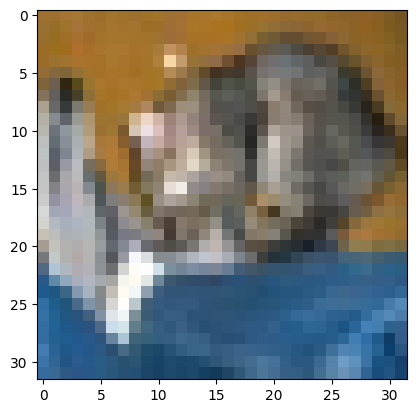

In [134]:
plt.imshow(data.squeeze(0).permute(1,2,0).cpu().numpy())

In [32]:
with torch.no_grad():
    data = data.unsqueeze(0).to('cuda')
    z = encoder(data)
    z_q, _, _ = vq(z)
    x_hat = decoder(z_q)

In [33]:
x_hat.shape

torch.Size([1, 3, 32, 32])

In [34]:
x_hat = x_hat.squeeze(0)
x_hat = x_hat.permute(1,2,0)
x_hat = x_hat.cpu().numpy()

In [35]:
import matplotlib.pyplot as plt

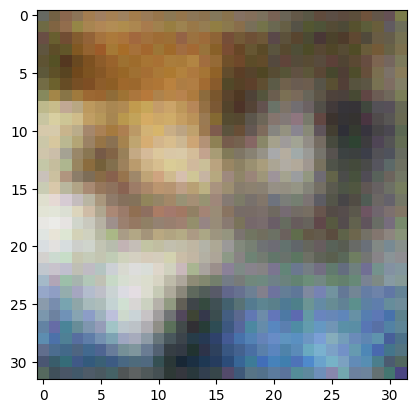

In [36]:
plt.imshow(x_hat)

In [44]:
# now that we have a trained model, we gonna futher compress the 
# encoded out using entropy encoding(huffman/ arithmetic)
# which is basically giving shorter codes for common ones and 
# longer codes for uncommon 

In [43]:
class HuffmanCoding:
    def __init__(self, dictt=None, symbol=None, prob=0, left=None, right=None):
        self.symbol = symbol
        self.prob = prob
        self.left = left
        self.right = right
        self.dictt = dictt
        self.root = None
        self.codes = {}
        
    def create_nodes(self):
        nodes = [HuffmanCoding(symbol=s, prob=p) for s, p in self.dictt.items()]
        while len(nodes) > 1:
            nodes = sorted(nodes, key=lambda x: x.prob)
            left = nodes.pop(0)
            right = nodes.pop(0)
            merged = HuffmanCoding(symbol=None, prob=left.prob + right.prob, left=left, right=right)
            nodes.append(merged)
        self.root = nodes[0]
        return self.root
        
    def generate_codes(self, node=None, code=""):
        if node is None:
            node = self.root
            
        if node.symbol is not None:
            self.codes[node.symbol] = code
            return self.codes
            
        if node.left:
            self.generate_codes(node.left, code + '0' )
        if node.right:
            self.generate_codes(node.right, code + '1')
        return self.codes

    def encode(self, inp):
        return ''.join(self.codes[i] for i in inp)

    def decode(self, encoded):
        decoded_ = list()
        node = self.root
        for bit in encoded:
            node = node.left if bit == '0' else node.right
            if node.symbol is not None:
                decoded_.append(node.symbol)
                node = self.root
        return decoded_

In [96]:
ex_data = test_data[1][0]

In [97]:
with torch.no_grad():
    ex_data = ex_data.unsqueeze(0).to('cuda')
    z = encoder(ex_data)
    indices = vq.encode(z)
    

In [98]:
indices_flat = indices.flatten().tolist()

In [99]:
indices_flat

[238, 238, 34, 238, 103, 335, 427, 451, 70, 251, 7, 76, 190, 190, 349, 228]

In [100]:
from collections import Counter

In [101]:
count = Counter(indices_flat)

In [102]:
count

Counter({238: 3,
         34: 1,
         103: 1,
         335: 1,
         427: 1,
         451: 1,
         70: 1,
         251: 1,
         7: 1,
         76: 1,
         190: 2,
         349: 1,
         228: 1})

In [103]:
prob_dict = {k: v / sum(count.values()) for k, v in count.items()}
symbols = list(prob_dict.keys())
probs = list(prob_dict.values())

In [104]:
prob_dict

{238: 0.1875,
 34: 0.0625,
 103: 0.0625,
 335: 0.0625,
 427: 0.0625,
 451: 0.0625,
 70: 0.0625,
 251: 0.0625,
 7: 0.0625,
 76: 0.0625,
 190: 0.125,
 349: 0.0625,
 228: 0.0625}

In [105]:
huff = HuffmanCoding(dictt=prob_dict)
huff.create_nodes()
huff.generate_codes()

{228: '000',
 190: '001',
 34: '0100',
 103: '0101',
 335: '0110',
 427: '0111',
 451: '1000',
 70: '1001',
 251: '1010',
 7: '1011',
 76: '1100',
 349: '1101',
 238: '111'}

In [106]:
print(f"Codebook size: {len(huff.codes)}")
print(f"Example codes: {list(huff.codes.items())[:5]}")

Codebook size: 13
Example codes: [(228, '000'), (190, '001'), (34, '0100'), (103, '0101'), (335, '0110')]


In [108]:
encoded_bits = huff.encode(indices_flat)
print(f"Original: 16 indices × 9 bits = 144 bits")
print(f"Compressed: {len(encoded_bits)} bits")
print(f"Compression ratio: {144/len(encoded_bits):.2f}x")

Original: 16 indices × 9 bits = 144 bits
Compressed: 58 bits
Compression ratio: 2.48x


In [109]:
encoded_bits

'1111110100111010101100111100010011010101111000010011101000'

In [110]:
decoded = huff.decode(encoded_bits)

In [111]:
decoded

[238, 238, 34, 238, 103, 335, 427, 451, 70, 251, 7, 76, 190, 190, 349, 228]

In [112]:
def pad_bitstring(bitstring):
    padding = 8 - len(bitstring) % 8
    if padding != 8:
        bitstring += '0' * padding
    return bitstring, padding

def bitstring2bytes(bitstring):
    bitstring, padding = pad_bitstring(bitstring)
    byte_array = bytearray()
    for i in range(0, len(bitstring), 8):
        byte = bitstring[i:i+8]
        byte_array.append(int(byte, 2))
    return bytes(byte_array), padding

In [113]:
import pickle

In [114]:
compressed_bytes, padding = bitstring2bytes(encoded_bits)

In [115]:
compressed_data = {
    'compressed': compressed_bytes,
    'padding': padding,
    'shape': (4,4),
    'huffman_tree':huff.root,
    'code':huff.codes
}

In [116]:
with open('compressed_image.pkl', 'wb') as f:
    pickle.dump(compressed_data, f)

In [117]:
print(f"Saved {len(compressed_bytes)} bytes")
print(f"Original: {3*32*32} bytes")
print(f"Compression: {(3*32*32)/len(compressed_bytes):.1f}x")

Saved 8 bytes
Original: 3072 bytes
Compression: 384.0x


In [118]:
with open('compressed_image.pkl', 'rb') as f:
    data = pickle.load(f)

In [119]:
def bytes2bitstring(byte_data, padding):
    bitstring = ''.join(format(byte, '08b') for byte in byte_data)
    if padding:
        bitstring = bitstring[:-padding]
    return bitstring

In [120]:
bitstring = bytes2bitstring(data['compressed'], data['padding'])

In [121]:
huff.root = data['huffman_tree']
indices_decoded = huff.decode(bitstring)

In [122]:
indices_decoded

[238, 238, 34, 238, 103, 335, 427, 451, 70, 251, 7, 76, 190, 190, 349, 228]

In [123]:
with torch.no_grad():
    indices_tensor = torch.tensor(indices_decoded).view(1, 4, 4).to(device)
    z_q = F.embedding(indices_tensor.view(-1), vq.embed).view(1, 4, 4, -1)
    z_q = z_q.permute(0, 3, 1, 2).contiguous()
    reconstructed = decoder(z_q)

In [124]:
aa = reconstructed.squeeze(0).permute(1,2,0)

In [127]:
aa = aa.cpu().numpy()

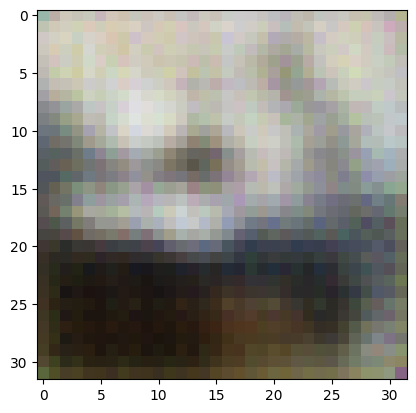

In [129]:
plt.imshow(aa)
plt.show()

In [ ]:
# not the best decoding, as the training wasnt that 
# good, maybe more epochs and better hyperparameter tuning will give
# better decoding